# Load Packages

In [1]:
#!/usr/bin/env python3
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import resample
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Load Data

In [2]:
customer_churn = pd.read_csv('customer-churn.csv')

names = ["gender", "Partner", "Dependents", "PhoneService", 
"MultipleLines", "InternetService", "OnlineSecurity",
"OnlineBackup", "DeviceProtection", "TechSupport", 
"StreamingMovies", "StreamingTV", "Contract", "PaperlessBilling", 
"PaymentMethod"]

churn = ["Continuing Service", "Churn"]

customer_churn_new = pd.get_dummies(customer_churn, columns=names)
del customer_churn_new['customerID'] 

# Clean Data

In [3]:
customer_churn_new["Churn"] = customer_churn_new["Churn"].map({'Yes':1, "No":0})

customer_churn_new["TotalCharges"] = customer_churn_new["TotalCharges"].replace(" ", np.nan)
customer_churn_new["TotalCharges"] = customer_churn_new["TotalCharges"].astype("float64")
customer_churn_new["TotalCharges"].fillna(customer_churn_new["TotalCharges"].mean(), inplace=True)

In [4]:
def print_churn_perc(data_frame, col):
    """Function used to print class distribution for our data set"""
    churn_vals = data_frame[col].value_counts()
    churn_vals = churn_vals.reset_index()
    # Create a function to output the percentage
    f = lambda x, y: 100 * (x / sum(y))
    for i in range(0, len(churn)):
        print('{0} accounts for {1:.2f}% of the Target class'\
              .format(churn[i], f(churn_vals[col].iloc[i],
                               churn_vals[col])))

print_churn_perc(customer_churn_new, "Churn")

Continuing Service accounts for 73.46% of the Target class
Churn accounts for 26.54% of the Target class


# Validation Set

In [5]:
sub_set, test_set = train_test_split(customer_churn_new,
                                          test_size = 0.25,
                                          random_state = 42)

## Upsampling 
Inspired by [this article](https://elitedatascience.com/imbalanced-classes)

In [6]:
training_set, validation_set = train_test_split(sub_set,
                                          test_size = 0.15,
                                          random_state = 42)

In [7]:
training_majority = training_set[training_set["Churn"] == 0]

In [8]:
training_majority.shape

(3320, 46)

In [9]:
training_minority = training_set[training_set["Churn"] == 1]

In [10]:
training_match = resample(training_minority, 
                     n_samples=3892,
                     replace=True, 
                     random_state=42)

In [11]:
training_match.shape

(3892, 46)

In [12]:
training_set_final = pd.concat([training_majority, training_match])

In [13]:
training_set_final["Churn"].value_counts()

1    3892
0    3320
Name: Churn, dtype: int64

In [14]:
feature_space = training_set_final.iloc[:, training_set_final.columns != "Churn"]
feature_class = training_set_final.iloc[:, training_set_final.columns == "Churn"]

In [15]:
feature_space.head()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,...,StreamingTV_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
5471,0,29,74.20,1993.25,1,0,1,0,1,0,...,0,1,0,0,0,1,0,0,1,0
781,0,5,44.80,220.45,1,0,0,1,0,1,...,0,1,0,0,1,0,0,0,0,1
6153,0,60,20.95,1270.55,0,1,0,1,0,1,...,0,0,0,1,0,1,1,0,0,0
3365,0,19,19.65,358.15,0,1,1,0,1,0,...,0,0,0,1,1,0,0,0,0,1
3292,0,5,50.95,229.40,1,0,1,0,1,0,...,1,1,0,0,0,1,0,1,0,0


# Fitting Model 

In [16]:
fit_gb = GradientBoostingClassifier(random_state=42,
                                    n_estimators=500)

# Parameter Grid Search

In [17]:
np.random.seed(42)
start = time.time()

param_dist = {"loss": ["deviance", "exponential"],
              "learning_rate": [0.1, 0.2, 0.3],
              "max_features": ['auto', 'sqrt', 'log2', None],
              "max_depth": [3, 2, 1]}

cv_gb = GridSearchCV(fit_gb, cv = 10,
                     param_grid=param_dist, 
                     n_jobs = 3)

cv_gb.fit(feature_space, feature_class["Churn"])
print('Best Parameters using grid search: \n', 
      cv_gb.best_params_)
end = time.time()
print('Time taken in grid search: {0: .2f}'.format(end - start))

Best Parameters using grid search: 
 {'learning_rate': 0.3, 'max_features': 'auto', 'max_depth': 3, 'loss': 'deviance'}
Time taken in grid search:  880.55


In [18]:
fit_gb.set_params(learning_rate=0.3, 
                  max_depth=3, 
                  loss="deviance", 
                  max_features="auto")

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [19]:
fit_gb.fit(feature_space, feature_class["Churn"])


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.3, loss='deviance', max_depth=3,
              max_features='auto', max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

# Feature Importance

In [20]:
importances_gb = fit_gb.feature_importances_
indices_gb = np.argsort(importances_gb)[::-1]

In [21]:
names_index = customer_churn_new.columns.tolist()
names_index.remove("Churn")

In [22]:
def variable_importance(importance, indices):
    """
    Purpose:
    ----------
    Prints dependent variable names ordered from largest to smallest
    based on gini or information gain for CART model. 
    
    Parameters:
    ----------
    names:      Name of columns included in model
    importance: Array returned from feature_importances_ for CART
                   models organized by dataframe index
    indices:    Organized index of dataframe from largest to smallest
                   based on feature_importances_

    Returns:
    ----------
    Print statement outputting variable importance in descending order
    """
    print("Feature ranking:")
    
    for f in range(len(names_index)):
        i = f
        print("%d. The feature '%s' \
has a Mean Decrease in Gini of %f" % (f + 1, 
                                         names_index[indices[i]], 
                                         importance[indices[f]]))

In [23]:
variable_importance(importances_gb, indices_gb)

Feature ranking:
1. The feature 'TotalCharges' has a Mean Decrease in Gini of 0.401059
2. The feature 'MonthlyCharges' has a Mean Decrease in Gini of 0.284867
3. The feature 'tenure' has a Mean Decrease in Gini of 0.070974
4. The feature 'PaymentMethod_Electronic check' has a Mean Decrease in Gini of 0.013859
5. The feature 'Contract_Month-to-month' has a Mean Decrease in Gini of 0.013514
6. The feature 'Contract_One year' has a Mean Decrease in Gini of 0.013269
7. The feature 'SeniorCitizen' has a Mean Decrease in Gini of 0.012148
8. The feature 'PaymentMethod_Mailed check' has a Mean Decrease in Gini of 0.011201
9. The feature 'gender_Male' has a Mean Decrease in Gini of 0.011030
10. The feature 'Dependents_No' has a Mean Decrease in Gini of 0.010102
11. The feature 'PaymentMethod_Bank transfer (automatic)' has a Mean Decrease in Gini of 0.009669
12. The feature 'TechSupport_No' has a Mean Decrease in Gini of 0.009451
13. The feature 'PaymentMethod_Credit card (automatic)' has a Mean

In [24]:
def variable_importance_plot(importance, indices):
    """
    Purpose
    ----------
    Prints bar chart detailing variable importance for CART model
    NOTE: feature_space list was created because the bar chart
    was transposed and index would be in incorrect order.
    Parameters
    ----------
    importance_desc: Array returned from feature_importances_ for CART
                    models organized in descending order
    indices: Organized index of dataframe from largest to smallest
                    based on feature_importances_
    Returns:
    ----------
    Returns variable importance plot in descending order
    """
    index = np.arange(len(names_index))

    importance_desc = sorted(importance)
    feature_space = []
    for i in range(44, -1, -1):
        feature_space.append(names_index[indices[i]])

    fig, ax = plt.subplots(figsize=(10, 10))

    ax.set_facecolor('#fafafa')
    plt.title('Feature importances for Random Forest Model\
    \nBreast Cancer (Diagnostic)')
    plt.barh(index,
         importance_desc,
         align="center",
         color = '#875FDB')
    plt.yticks(index,
           feature_space)

    plt.ylim(-1, 45)
    plt.xlim(0, max(importance_desc) + 0.01)
    plt.xlabel('Mean Decrease in Gini')
    plt.ylabel('Feature')

    plt.show()

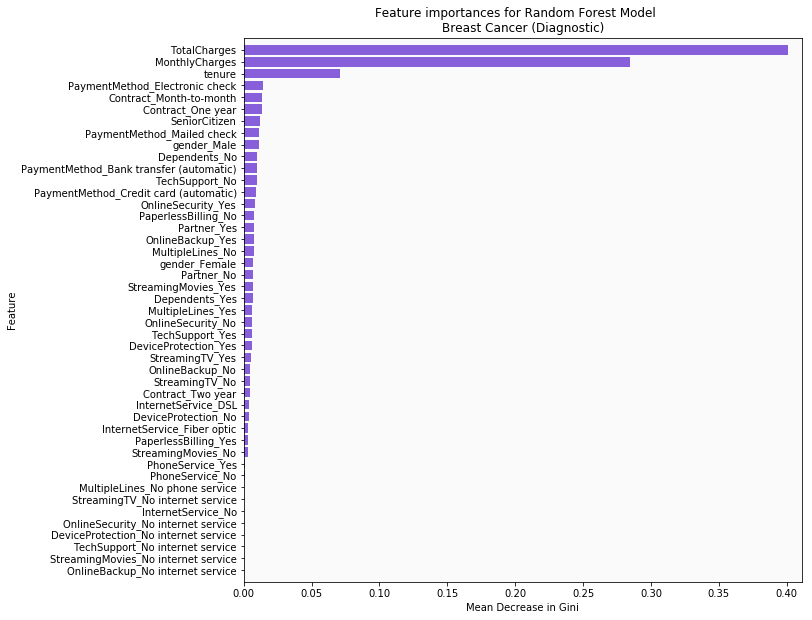

In [25]:
variable_importance_plot(importances_gb, indices_gb)

# Cross Validation

In [26]:
validation_space = validation_set.iloc[:, validation_set.columns != 'Churn']
validation_class = validation_set.iloc[:, validation_set.columns == 'Churn']
validation_class_set = validation_class.values.ravel()

In [27]:
n = KFold(n_splits=10)
cross_val_gb = cross_val_score(fit_gb, 
                validation_space, 
                validation_class["Churn"], 
                cv = n,
                verbose=1)

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    7.7s finished


In [28]:
for i in range(0, len(cross_val_gb)):
    print("Cross Validation Job {0}: {1: 0.3f}".format(i, cross_val_gb[i]))
print("Cross Validation Average: {0: 0.3f} (+/- {1: 0.3f})".format(cross_val_gb.mean(), cross_val_gb.std() /2))

Cross Validation Job 0:  0.863
Cross Validation Job 1:  0.787
Cross Validation Job 2:  0.738
Cross Validation Job 3:  0.772
Cross Validation Job 4:  0.734
Cross Validation Job 5:  0.759
Cross Validation Job 6:  0.734
Cross Validation Job 7:  0.722
Cross Validation Job 8:  0.823
Cross Validation Job 9:  0.696
Cross Validation Average:  0.763 (+/-  0.024)


# Test Set Metrics
Now that I've decided that this model is the best we will compare to unseen data. 

In [29]:
def plot_roc_curve(fpr, tpr, auc, mod, xlim=None, ylim=None):
    """
    Purpose
    ----------
    Function creates ROC Curve for respective model given selected parameters.
    Optional x and y limits to zoom into graph
    Parameters
    ----------
    * fpr: Array returned from sklearn.metrics.roc_curve for increasing
            false positive rates
    * tpr: Array returned from sklearn.metrics.roc_curve for increasing
            true positive rates
    * auc: Float returned from sklearn.metrics.auc (Area under Curve)
    * mod: 	String represenation of appropriate model, can only contain the
            following: ['knn', 'rf', 'nn']
    * xlim: Set upper and lower x-limits
    * ylim: Set upper and lower y-limits
    """
    mod_list = ['gb']
    method = [('Gradient Boosting Machine', 'navy')]

    plot_title = ''
    color_value = ''
    for i in range(0, len(mod_list)):
        if mod_list[i] == mod:
            plot_title = method[i][0]
            color_value = method[i][1]

    fig, ax = plt.subplots(figsize=(10, 10))
    ax.set_facecolor('#fafafa')

    plt.plot(fpr, tpr,
        color=color_value,
        linewidth=1)
    plt.title('ROC Curve For {0} (AUC = {1: 0.3f})'\
        .format(plot_title, auc))

    plt.plot([0, 1], [0, 1], 'k--', lw=2) # Add Diagonal line
    plt.plot([0, 0], [1, 0], 'k--', lw=2, color = 'black')
    plt.plot([1, 0], [1, 1], 'k--', lw=2, color = 'black')
    if xlim is not None:
        plt.xlim(*xlim)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.show()

In [30]:
print(customer_churn_new.shape)
print(training_set.shape)
print(validation_space.shape)
print(test_set.shape)

(7043, 46)
(4489, 46)
(793, 45)
(1761, 46)


In [31]:
test_set_feat = test_set.iloc[:, test_set.columns != "Churn"]
test_class_set = test_set.iloc[:, test_set.columns == "Churn"]

In [32]:
predictions_prob = fit_gb.predict_proba(test_set_feat)[:, 1]

# ROC Curve stuff
fpr2, tpr2, _ = roc_curve(test_class_set["Churn"],
    predictions_prob)

auc_gb = auc(fpr2, tpr2)

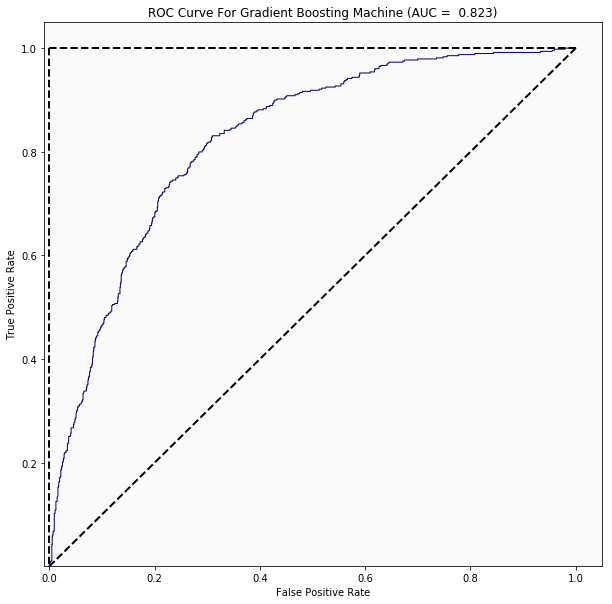

In [33]:
plot_roc_curve(fpr2, tpr2, auc_gb, "gb",
               xlim=(-0.01, 1.05), 
               ylim=(0.001, 1.05))

In [34]:
predictions_gb = fit_gb.predict(test_set_feat)

In [35]:
print("{0: 0.3f}% test error rate".format((1 - fit_gb.score(test_set_feat, test_class_set["Churn"])) * 100))

 23.169% test error rate


In [36]:
test_crosstb_comp = pd.crosstab(index = test_class_set["Churn"],
                           columns = predictions_gb)

test_crosstb = test_crosstb_comp.as_matrix()

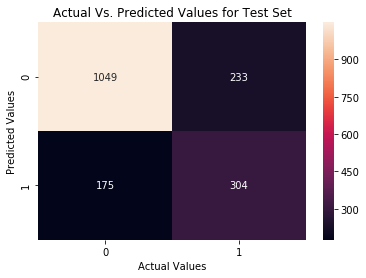

In [37]:
sns.heatmap(test_crosstb_comp,
           annot=True,
           fmt=".0f")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual Vs. Predicted Values for Test Set")
plt.show()